# Analyzing Urban Areas

This notebook shows how we can perform POI-based analysis for urban areas. Discritization of urban areas allows spatial analysis. For example, a very typical use case is to create heatmaps. You can read any spatial data that you have (e.g., real estate prices, air pollution, etc.) and start to analyze them based on the created tiles. Here we use Open Street Map to show several example use cases.

To run this notebook, in addition to `tesspy`, you need `contextily` for basemap visualization and `esda` and `lybpysal` for spatial analysis.

In [1]:
# import os
# import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (8,8)

import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon, MultiPoint
import contextily as ctx

import esda 
import libpysal as lp

# import statsmodels.api as sm
# from scipy.stats import norm

In [2]:
from tesspy import Tessellation

# Area

We use **Frankfurt am Main** in Germany as a case study. First we get the city boundry. Then we generate different tessellations. 

In [25]:
ffm= Tessellation('Frankfurt am Main')
ffm_polygon=ffm.get_polygon()

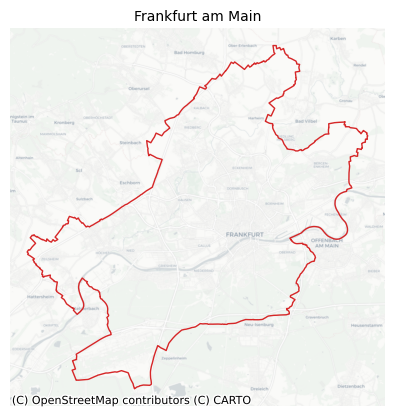

In [31]:
# visualization of area
ax= ffm_polygon.to_crs('EPSG:3857').plot(facecolor='none', edgecolor='tab:red',lw=1, figsize=(5,5))
ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()
ax.set_title('Frankfurt am Main', fontsize=10)
plt.show()

In [44]:
ffm_asq = ffm.adaptive_squares(start_resolution=13, threshold=500, timeout=60,
                               poi_categories=['shop','building','amenity','office','public_transport'])

/home/siavash/anaconda3/envs/tessDev/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [5]:
# Tessellation

ffm_sqr_16=ffm.squares(16)
ffm_hex_9=ffm.hexagons(9)

ffm_asq = ffm.adaptive_squares(start_resolution=13, threshold=500, timeout=60,
                               poi_categories=['shop','building','amenity','office','public_transport'])

ffm_voronoi_kmeans= ffm.voronoi(poi_categories=['shop','building','amenity','office','public_transport'], 
                         n_polygons=1000)

ffm_voronoi_hdbscan = ffm.voronoi(cluster_algo='hdbscan',min_cluster_size=10,
                                  poi_categories=['shop','building','amenity','office','public_transport'])

ffm_cb = ffm.city_blocks(n_polygons=1000, detail_deg=None)

/home/siavash/anaconda3/envs/tessDev/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


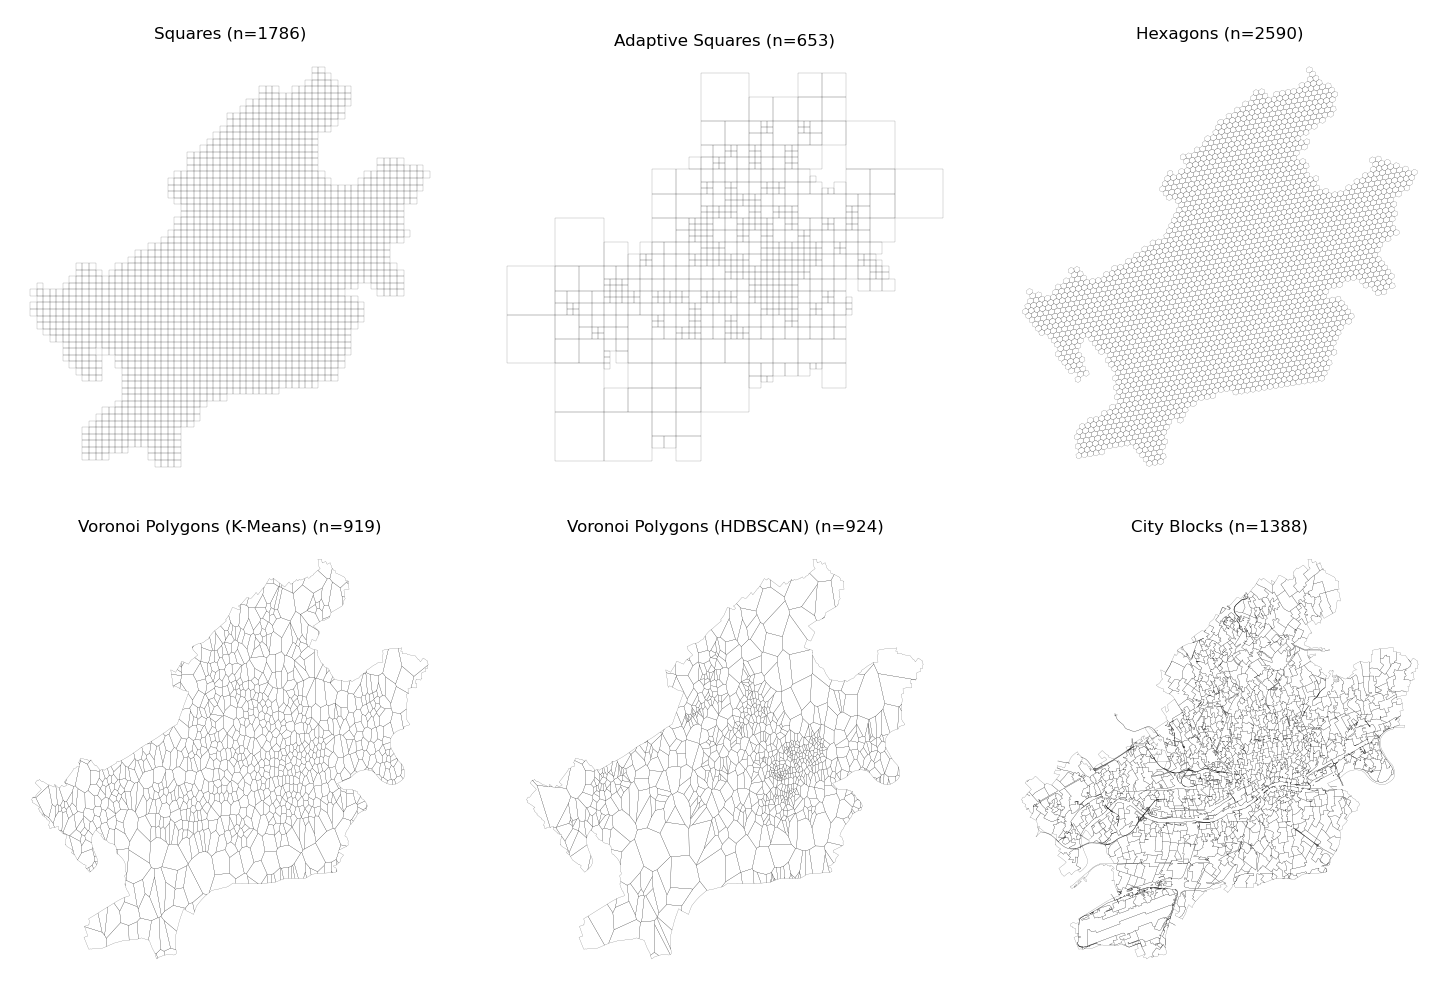

In [38]:
lgu_dfs=[ffm_sqr_16,ffm_asq, ffm_hex_9,ffm_voronoi_kmeans,ffm_voronoi_hdbscan,ffm_cb]
titles=['Squares','Adaptive Squares','Hexagons','Voronoi Polygons (K-Means)','Voronoi Polygons (HDBSCAN)','City Blocks']

fig,axs=plt.subplots(2,3, figsize=(15,10))
for ax, df, title in zip(axs.flatten(),lgu_dfs, titles) :
    ax.set_axis_off()
    df.plot(ax=ax,facecolor='none', edgecolor='k', lw=0.1)
    ax.set_title(f'\n{title} (n={len(df)})')
    
plt.tight_layout()
plt.show()

Let's take a look at the retrieved POI data from OSM:

In [46]:
poi_df= ffm.get_poi_data()

In [51]:
poi_df.head()

,type,geometry,tags,center_latitude,center_longitude,amenity,building,office,public_transport,shop
0,way,"[{'lat': 50.1074607, 'lon': 8.734269}, {'lat':...","{'access': 'customers', 'amenity': 'parking', ...",50.107625,8.734458,True,False,False,False,False
1,way,"[{'lat': 50.1670562, 'lon': 8.6760002}, {'lat'...","{'amenity': 'school', 'contact:email': 'schull...",50.167461,8.675039,True,False,False,False,False
2,way,"[{'lat': 50.1488198, 'lon': 8.6928804}, {'lat'...","{'amenity': 'prison', 'barrier': 'fence', 'nam...",50.149950,8.695300,True,False,False,False,False
3,way,"[{'lat': 50.1446936, 'lon': 8.6511394}, {'lat'...","{'addr:city': 'Frankfurt am Main', 'addr:house...",50.145195,8.650782,True,False,False,False,False
4,way,"[{'lat': 50.0518233, 'lon': 8.5654572}, {'lat'...","{'addr:city': 'Frankfurt am Main', 'addr:postc...",50.052712,8.568809,False,True,False,False,False


This dataframe contains geometry and other tags of the selected POI categories. We can take a look at the total number of each POI category in Frankfurt:

In [50]:
poi_df.iloc[:, -5:].sum()

amenity              19789
building            144468
office                 689
public_transport      5157
shop                  4357
dtype: int64

We can use `amenity` to generate heatmaps based on the created polygons (tiles). First we count `amenity` in each polygon for each tessellation method. Then we can visualize the resulted counts.

In [ ]:
poi_data=gpd.GeoDataFrame(geometry=poi[['lon','lat']].apply(Point, axis=1).values,
                          crs='EPSG:4326')

In [ ]:
for df in lgu_dfs:
    df.reset_index(inplace=True)
    df.rename(columns={'index':'tile_id'}, inplace=True)

We can calcualte the areas and see how they differ between different tessellation methods.

In square and hexagon methods, the area of polygons is (almost) constant. By Voronoi and city blocks, it varys. We can take a look at the histogram to investigate it:

In order to investigate the spatial correlation, we can calculate Moran's I index and spatial lags.